In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
# import pytorch_lightning as pl

In [2]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor

In [3]:
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

In [4]:
# Define paths
data_path = "/home/naradalinux/dev/GCNTFT/data/processed/data_w_geo_v3.csv"
embeddings_path = "/home/naradalinux/dev/GCNTFT/data/embeddings_v2/tft_ready_embeddings.csv"

# Load the air quality data
air_quality_df = pd.read_csv(data_path)
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['datetime'])

# Load the embeddings
embeddings_df = pd.read_csv(embeddings_path, index_col=0)


In [20]:

# Convert the datetime to proper format for TimeSeriesDataSet
air_quality_df['time_idx'] = (air_quality_df['datetime'] - air_quality_df['datetime'].min()).dt.total_seconds() // 3600
air_quality_df['time_idx'] = air_quality_df['time_idx'].astype(int)
air_quality_df = air_quality_df.sort_values(['station_loc', 'time_idx'])

# Add a group_id column (required for pytorch-forecasting)
station_ids = air_quality_df['station_loc'].unique()
station_mapping = {station: idx for idx, station in enumerate(station_ids)}
air_quality_df['group_id'] = air_quality_df['station_loc'].map(station_mapping)

necessary_columns = ['datetime', 'time_idx', 'PM2.5 (ug/m3)', 'latitude', 'longitude', 'station_loc', 'group_id']
air_quality_df = air_quality_df[necessary_columns]
air_quality_df.rename(columns={'PM2.5 (ug/m3)': 'PM25'}, inplace=True)
# air_quality_df['station_loc'] = air_quality_df['station_loc'].astype('category')

In [6]:
# # Merge embeddings with the air quality data
# # First, create a column for the embedding index
# max_time_idx = air_quality_df['time_idx'].max()
# window_size = 24  # assuming 24-hour window size used in GNN

# # We need to match embeddings to the right time points
# processed_data = []

# for station in station_ids:
#     station_data = air_quality_df[air_quality_df['station_loc'] == station]
    
#     # For each time point with sufficient history
#     for t in range(window_size, int(max_time_idx) + 1):
#         if t in station_data['time_idx'].values:
#             curr_data = station_data[station_data['time_idx'] == t].iloc[0].to_dict()
            
#             # Find the embedding for this station at this time point
#             station_idx = station_mapping[station]
#             embedding_idx = (t - window_size) * len(station_ids) + station_idx
            
#             if embedding_idx < len(embeddings_df):
#                 # Add embedding features
#                 for i in range(1, embeddings_df.shape[1]):
#                     curr_data[f'embedding_{i}'] = embeddings_df.iloc[embedding_idx, i]
                
#                 processed_data.append(curr_data)

# # Create new dataframe with embeddings
# combined_df = pd.DataFrame(processed_data)

In [7]:
# combined_df.to_csv("/home/naradalinux/dev/GCNTFT/data/processed/data_w_geo_v4.csv", index=False)
combined_df = pd.read_csv("/home/naradalinux/dev/GCNTFT/data/processed/data_w_geo_v4.csv")

In [8]:
combined_df.head()

,datetime,time_idx,PM25,latitude,longitude,station_loc,group_id,embedding_1,embedding_2,embedding_3,...,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32
0,2022-04-01 23:00:00,24,174.0,28.797312,77.138667,"Alipur, Delhi",0,0.659644,0.973403,0.950521,...,0.360108,0.385222,0.904384,-0.391190,0.533015,-0.898249,0.586380,0.378052,0.627379,0.274174
1,2022-04-02 00:00:00,25,160.0,28.797312,77.138667,"Alipur, Delhi",0,0.734946,0.956723,0.985116,...,0.432373,0.514372,0.977635,-0.340597,0.729516,-0.851131,0.709411,0.474948,0.612100,0.440182
2,2022-04-02 01:00:00,26,139.0,28.797312,77.138667,"Alipur, Delhi",0,0.758993,0.771369,0.927283,...,0.405998,0.582113,0.883297,-0.208380,0.772565,-0.808870,0.679129,0.457232,0.410480,0.534738
3,2022-04-02 02:00:00,27,156.0,28.797312,77.138667,"Alipur, Delhi",0,0.691837,0.459378,0.813349,...,0.223756,0.533677,0.677830,0.001629,0.582883,-0.752520,0.476877,0.226231,-0.004298,0.443733
4,2022-04-02 03:00:00,28,157.0,28.797312,77.138667,"Alipur, Delhi",0,0.719003,0.367890,0.719558,...,0.195613,0.630484,0.498522,0.134125,0.480636,-0.813771,0.358310,0.148527,-0.315213,0.483661


In [9]:
# Define prediction parameters
max_prediction_length = 24  # predict 24 hours into the future
max_encoder_length = 72     # use 72 hours of history

# Create training dataset
training_cutoff = combined_df["time_idx"].max() - max_prediction_length

In [10]:
training_cutoff

8736

In [11]:
combined_df['station_loc'] = combined_df['station_loc'].astype('category')
# combined_df.dtypes

In [12]:
# Prepare the dataset
tft_dataset = TimeSeriesDataSet(
    data=combined_df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="PM25",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,  # allow for smaller encoder lengths
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["station_loc"],
    static_reals=["latitude", "longitude"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "PM25",
    ] + [f'embedding_{i}' for i in range(1, embeddings_df.shape[1])],
    target_normalizer=GroupNormalizer(
        groups=["group_id"], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [13]:
batch_size = 64
train_dataloader = tft_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = tft_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [14]:
# Define the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    tft_dataset,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

/home/naradalinux/miniconda3/envs/graph-tft/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/naradalinux/miniconda3/envs/graph-tft/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [15]:
# Verify that the model is a LightningModule
print(f"Model is LightningModule: {isinstance(tft, pl.LightningModule)}")

Model is LightningModule: True


In [16]:
# Configure trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Create directory for checkpoints if it doesn't exist
import os
os.makedirs("models", exist_ok=True)

# Updated Trainer initialization for newer PyTorch Lightning versions
trainer = pl.Trainer(
    max_epochs=30,
    devices=1, 
    accelerator="gpu", 
    gradient_clip_val=0.1,
    # limit_train_batches=50,
    callbacks=[lr_monitor, early_stop_callback],
    enable_checkpointing=True,
    default_root_dir="models"  # directory to save checkpoints
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/naradalinux/miniconda3/envs/graph-tft/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [17]:
# Train the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 444    | train
3  | prescalers                         | ModuleDict                      | 1.3 K  | train
4  | static_variable_selection          |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/naradalinux/miniconda3/envs/graph-tft/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/naradalinux/miniconda3/envs/graph-tft/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [18]:
# Save the trained model
trainer.save_checkpoint("models/tft_air_quality_forecast_1ep.ckpt")

In [ ]:
# Get the last available data point for each station
last_data = combined_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)

# Create a prediction dataset
pred_dataset = TimeSeriesDataSet(
    data=last_data,
    time_idx="time_idx",
    target="PM25",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length // 2,  # allow for smaller encoder lengths
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["station_loc"],
    static_reals=["latitude", "longitude"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "PM25",
    ] + [f'embedding_{i}' for i in range(1, embeddings_df.shape[1])],
    target_normalizer=GroupNormalizer(
        groups=["group_id"], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

/tmp/ipykernel_1102/3770776148.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last_data = combined_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)
/tmp/ipykernel_1102/3770776148.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_data = combined_df.groupby('station_loc').apply(lambda x: x.iloc[-max_encoder_length:]).reset_index(drop=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/naradalinux/miniconda3/envs/graph-tft/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


KeyError: 'PM2.5 (ug/m3)'

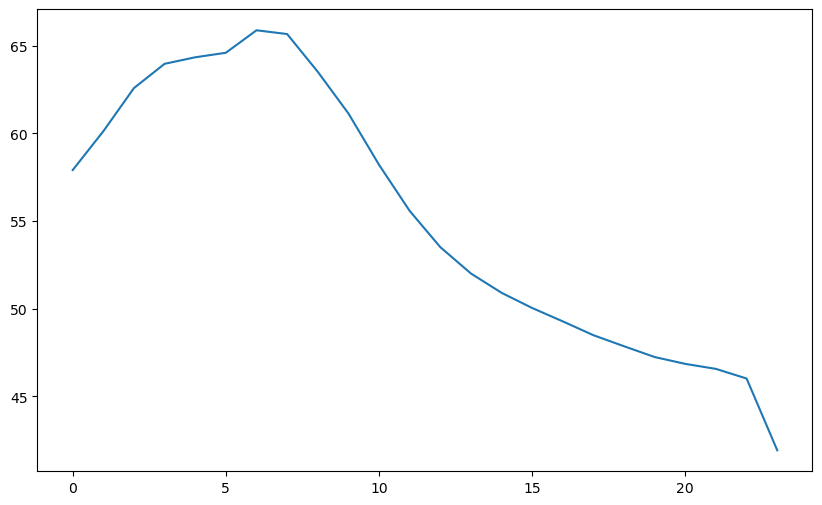

In [ ]:
# Make predictions
predictions = tft.predict(pred_dataset)

# Plot predictions for each station
for station in station_ids:
    station_idx = station_mapping[station]
    station_preds = predictions[station_idx].detach().cpu().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_prediction_length), station_preds, label='Prediction')
    
    # Get historical data for comparison
    historical = combined_df[combined_df['station_loc'] == station].tail(max_encoder_length)['PM25'].values
    plt.plot(range(-len(historical), 0), historical, label='Historical')
    
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.title(f'24-Hour Air Quality Forecast for Station {station}')
    plt.xlabel('Hours')
    plt.ylabel('PM25')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'outputs/images/station_{station}_forecast.png')
    plt.close()

print("Forecasting completed. Plots saved to outputs/images/")